# Objective

The objective of this notebook, is to learn how to transform a time-series problem (demand forecasting) into a tabular one.

For this we will use the M5 competition dataset, large and popular dataset.

In [1]:
!pip install -q eccd_datasets pygradus

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.9/223.9 kB 11.3 MB/s eta 0:00:00


In [2]:
STUDENT_NAME = "Juan-Ignacio-Briozzo"
COURSE_NAME = "eccd-oct23"
EXERCISE_NAME = "demand-forecsting"

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display

import matplotlib.pyplot as plt
import lightgbm as lgb

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

from eccd_datasets import load_m5

from pygradus import create_exercise, check_solution

# Preparing the dataset

Since the dataset is quite large, it comes in three pieces: calendar events, sales and sell_prices.

In [4]:
datasets = load_m5()
datasets.keys()

dict_keys(['calendar', 'sales', 'sell_prices'])

In [5]:
df_calendar = datasets["calendar"]
df_calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,None,None,None,None,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,None,None,None,None,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,None,None,None,None,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,None,None,None,None,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,None,None,None,None,1,0,1


In [6]:
df_sales = datasets["sales"]
df_sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [7]:
df_prices = datasets["sell_prices"]
df_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [8]:
def get_data_from_id(id_: str, sales: pd.DataFrame, prices: pd.DataFrame, calendar: pd.DataFrame) -> pd.DataFrame:
    """
    Extracts the dataframe associated with a single item id in long format.
    """

    df = sales[sales["id"] == id_].drop(columns=["id"])
    df = pd.melt(
        df,
        id_vars=[
            "item_id", "dept_id", "cat_id", "store_id", "state_id"],
        var_name = "d",
        value_name = "units_sold"

    )

    df = df.merge(calendar, on="d", how="left")
    df = df.merge(prices, on=["item_id", "store_id", "wm_yr_wk"], how="left")
    df["date"] = pd.to_datetime(df["date"])

    return df


In [9]:
ID = "HOBBIES_1_001_CA_1_validation"
df_id = get_data_from_id(ID, df_sales, df_prices, df_calendar)
print(df_id.shape)
df_id.head()

(1913, 21)


,item_id,dept_id,cat_id,store_id,state_id,d,units_sold,date,wm_yr_wk,weekday,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,...,1,2011,None,None,None,None,0,0,0,NaN
1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_2,0,2011-01-30,11101,Sunday,...,1,2011,None,None,None,None,0,0,0,NaN
2,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_3,0,2011-01-31,11101,Monday,...,1,2011,None,None,None,None,0,0,0,NaN
3,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_4,0,2011-02-01,11101,Tuesday,...,2,2011,None,None,None,None,1,1,0,NaN
4,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_5,0,2011-02-02,11101,Wednesday,...,2,2011,None,None,None,None,1,0,1,NaN


Text(0, 0.5, '# Units sold')

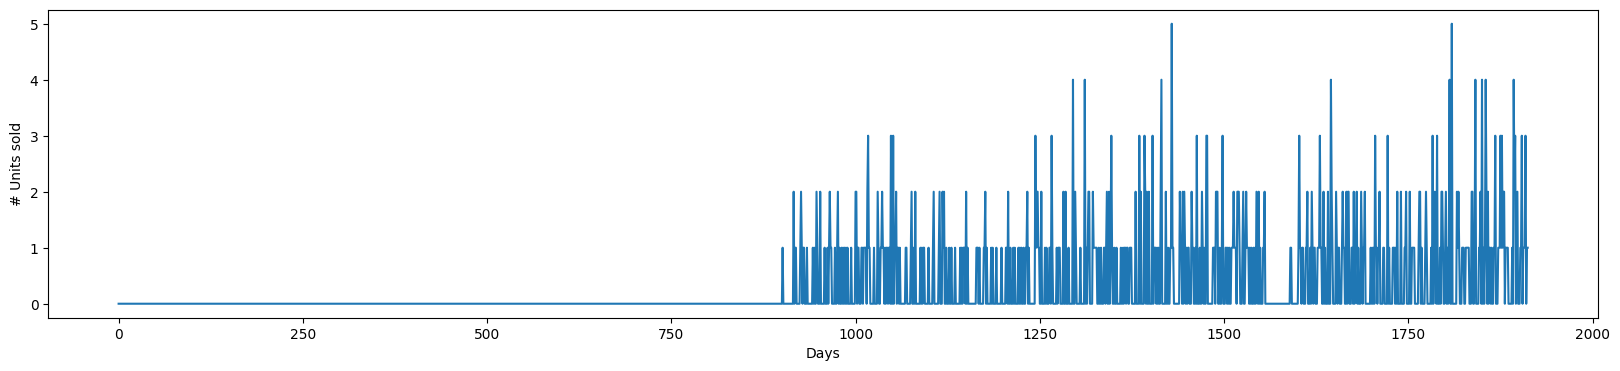

In [10]:
fig, ax = plt.subplots(figsize=(20, 4))

ax.plot(df_id["units_sold"])
ax.set_xlabel("Days")
ax.set_ylabel("# Units sold")

We can drop all the attributes that describe the price but don't change across rows since they will not provide useful informaton for training a model.

Furthermore, there are many attributes that are redundant and can be removed.

In [11]:
df_id = df_id.drop(columns=[
    "item_id", "dept_id", "state_id", "cat_id", "store_id", "d", "wm_yr_wk",
    "weekday", "month", "year", "wday"
])
df_id.head()

,units_sold,date,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,0,2011-01-29,None,None,None,None,0,0,0,NaN
1,0,2011-01-30,None,None,None,None,0,0,0,NaN
2,0,2011-01-31,None,None,None,None,0,0,0,NaN
3,0,2011-02-01,None,None,None,None,1,1,0,NaN
4,0,2011-02-02,None,None,None,None,1,0,1,NaN


We observe that for some events we don't have a price. We can assume that in those cases, the price is equal to the oldest price available.

In [12]:
df_id["sell_price"] = df_id["sell_price"].bfill()

In [13]:
df_id.head()

,units_sold,date,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,0,2011-01-29,None,None,None,None,0,0,0,9.58
1,0,2011-01-30,None,None,None,None,0,0,0,9.58
2,0,2011-01-31,None,None,None,None,0,0,0,9.58
3,0,2011-02-01,None,None,None,None,1,1,0,9.58
4,0,2011-02-02,None,None,None,None,1,0,1,9.58


In [16]:
def build_temporal_features(date_variable: str, df: pd.DataFrame) -> pd.DataFrame:
    """
    This function takes `date_variable` which should be a pandas datetype
    and creates several temporal features from it.

    In particular, it should create the additional columns in the dataframe

    Asume that all variables are in the range [0, x])

    `day_of_month`
    `month` (Jan = 0)
    `day_of_week` (Monday=0, Sunday= 6)
    `day_of_week_sin`
    `day_of_week_cos`
    `month_cos`
    `month_sin`
    `day_of_month_sin`
    `day_of_month_cos`
    `lag_1`
    `lag_7`

    Remember to sort the dataframe using the data varaible with the most
    recent values in the bottom.

    """
    #Empezamos haciendo el sort de los valores según la fecha
    df = df.sort_values(by=date_variable)
    #Creamos las columnas para el día del mes, el mes (haciendo que enero empiece en 0) y el día de la semana
    df['day_of_month'] = df[date_variable].dt.day
    df['month'] = df[date_variable].dt.month -1
    df['day_of_week'] = df[date_variable].dt.dayofweek

    #Creamos el encoding para el seno y el coseno para cada una de las columnas anteriormente creadas
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    df['days_in_month'] = df[date_variable].dt.days_in_month
    df['day_of_month_sin'] = np.sin(2 * np.pi * (df['day_of_month'] -1) / 31)
    df['day_of_month_cos'] = np.cos(2 * np.pi * (df['day_of_month'] -1) / 31)

    #Finalmente, creamos columnas para cada uno de los lags solicitados
    df['lag_1'] = df["units_sold"].shift(1).fillna(0)
    df['lag_2'] = df["units_sold"].shift(2).fillna(0)
    df['lag_7'] = df["units_sold"].shift(7).fillna(0)
    df['lag_14'] = df["units_sold"].shift(14).fillna(0)

    return df
    # Write your code here


In [17]:
df  = build_temporal_features("date", df_id)

In [18]:
df.head()

,units_sold,date,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,...,day_of_week_cos,month_sin,month_cos,days_in_month,day_of_month_sin,day_of_month_cos,lag_1,lag_2,lag_7,lag_14
0,0,2011-01-29,None,None,None,None,0,0,0,9.58,...,-0.222521,0.0,1.000000,31,-0.571268,0.820763,0.0,0.0,0.0,0.0
1,0,2011-01-30,None,None,None,None,0,0,0,9.58,...,0.623490,0.0,1.000000,31,-0.394356,0.918958,0.0,0.0,0.0,0.0
2,0,2011-01-31,None,None,None,None,0,0,0,9.58,...,1.000000,0.0,1.000000,31,-0.201299,0.979530,0.0,0.0,0.0,0.0
3,0,2011-02-01,None,None,None,None,1,1,0,9.58,...,0.623490,0.5,0.866025,28,0.000000,1.000000,0.0,0.0,0.0,0.0
4,0,2011-02-02,None,None,None,None,1,0,1,9.58,...,-0.222521,0.5,0.866025,28,0.201299,0.979530,0.0,0.0,0.0,0.0


In [19]:
row = df.iloc[1020]
assert np.allclose(row["day_of_week"], 3)
assert np.allclose(row["day_of_month"], 14)
assert np.allclose(row["month_sin"], -0.866025)
assert np.allclose(row["month_cos"], 0.5)
assert np.allclose(row["day_of_week_sin"], 0.433884)
assert np.allclose(row["day_of_week_cos"], -0.900969)
assert np.allclose(row["day_of_month_cos"], -0.874347)
assert np.allclose(row["lag_1"], 1)
assert np.allclose(row["lag_2"], 1)
assert np.allclose(row["lag_14"], 0)

answer_month = row["month"]
answer_month_sin = row["day_of_month_sin"]
answer_lag7 = row["lag_7"]

print(answer_month)
print(answer_month_sin)
print(answer_lag7)

10
0.48530196253108104
1.0


# Splitting the dataset

Unlike normal problems with tabular data, we can't randomly split the data (since each row has a temporal component).

For this we will manually split the dataset and keep the last 30 as test data.

In [20]:
y = df.pop("units_sold")
X = df.copy()

In [21]:
X_train, y_train = X.iloc[:-30], y.iloc[:-30]
X_test, y_test = X.iloc[-30:], y.iloc[-30:]

In [22]:
X_train.shape, y_train.shape

((1883, 23), (1883,))

In [23]:
X_test.shape, y_test.shape

((30, 23), (30,))

# Training with a simple AR model

In [24]:
arima = ARIMA(y_train, order=(7, 1, 0))
arima_res = arima.fit()

In [25]:
y_pred = arima_res.forecast(steps=30)
y_pred.head()

1883    1.568404
1884    1.487841
1885    1.610253
1886    1.349949
1887    1.329466
Name: predicted_mean, dtype: float64

In [26]:
mean_squared_error(y_pred, y_test.values, squared=True)

1.3100756698404203

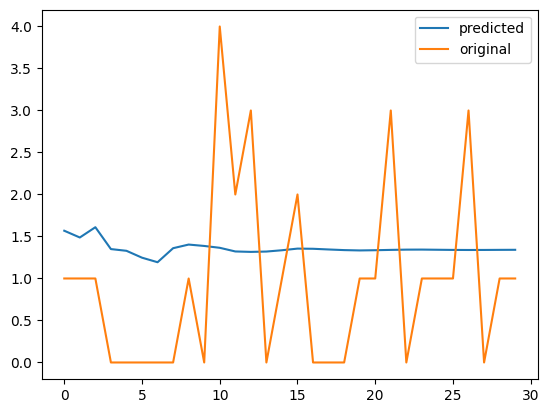

In [27]:
fig, ax = plt.subplots()
ax.plot(y_pred.values, label="predicted")
ax.plot(y_test.values, label="original")
ax.legend()

# Training using ML with Tabular Data

For simplicity we are going to use only the numerical features, without trying to properly encode the other ones.

In [28]:
params = {
    'max_depth': 4,
    'learning_rate': 0.01,
    'n_estimators': 450,
    'boosting_type': 'gbdt',
    'seed': 200,
    'num_threads': 1
}

model = lgb.LGBMRegressor(**params)

model.fit(X_train.select_dtypes(include=["float", "int"]), y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 177
[LightGBM] [Info] Number of data points in the train set: 1883, number of used features: 18
[LightGBM] [Info] Start training from score 0.303240
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

LGBMRegressor(learning_rate=0.01, max_depth=4, n_estimators=450, num_threads=1,
              seed=200)

In [29]:
y_pred = model.predict(X_test.select_dtypes(include=["float", "int"]))

In [30]:
mean_squared_error(y_pred, y_test.values, squared=True)

1.318277316028528

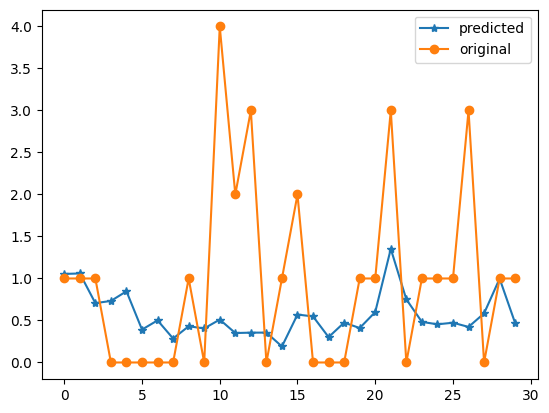

In [31]:
fig, ax = plt.subplots()
ax.plot(y_pred, label="predicted", marker="*")
ax.plot(y_test.values, label="original", marker="o")
ax.legend()

# Summary

We showed how we can build a tabular dataset from a time-series and how we can use traditional techniques such as `Regression Trees` to train such model.

In this example our analysis was quite basic and we kept only a minium number of variables.

Furthermore, an approach that was not explored is to train several items at the same (which requires more computing power), which can further incrase the performance of the model.

In [32]:

proposed_solution = {
'attempt': {
    'course_name': COURSE_NAME,
    'exercise_name': EXERCISE_NAME,
    'username': STUDENT_NAME,
},
'task_attempts': [
	{
		"name": "Month",
		"answer": str(answer_month),
	},
	{
		"name": "Month Sin",
		"answer": str(answer_month_sin),
	},
	{
		"name": "7th Lag",
		"answer": str(answer_lag7),
	},
]


}
check_solution(proposed_solution)


|                    Task Name                     |       Status       |
|--------------------------------------------------|--------------------|
|--------------------------------------------------|--------------------|
|                      Month                       |      Correct       |
|--------------------------------------------------|--------------------|
|                    Month Sin                     |      Correct       |
|--------------------------------------------------|--------------------|
|                     7th Lag                      |      Correct       |
|--------------------------------------------------|--------------------|
